In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Parrallel cores of a server
p = 8

# Reliability of a server
r = 0.999

# Times of a day
times = np.arange(0,24,0.1)

In [16]:
# Find the cost of a server with given parameters of processing power and realiability

def Cost(c,r):
    """
    Cost of a server with given parameters of processing power and realiability
    
    Parameters
    ----------
    p : int, Number of cores
    r : float (0,1), Reliability
    """
    # if p < 0 or r <= 0 or r >= 1:
    #     raise ValueError("Invalid input")
    base = 50
    cores = c*20
    reliability = np.tan(r + np.pi/2 - 1)
    
    return base+cores+reliability

In [5]:
# Distributions of client requests dependent on the time of day
def SpikeyDistribution(mean, std, spike=3):
    
    def dist(t):

        if t < 0 or t > 24:
            raise ValueError("Invalid input")
        if (t > 7 and t < 9) or (t > 17 and t < 19):
            return max(int(np.random.normal(mean*3, std)), 0)
        return max(int(np.random.normal(mean, std)), 0)
    
    return dist

Text(0.5, 1.0, 'Distribution of Client Requests')

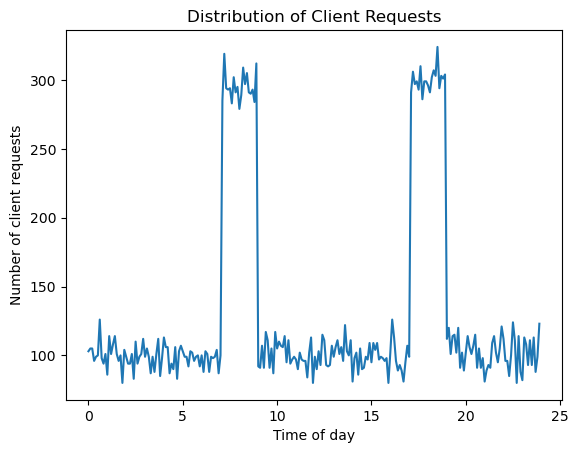

In [35]:
clients = SpikeyDistribution(100, 10)
plt.plot(np.arange(0,24,0.1), [clients(t) for t in np.arange(0,24,0.1)])
plt.xlabel("Time of day")
plt.ylabel("Number of client requests")
plt.title("Distribution of Client Requests")

In [7]:
# Server class to simulate the server
class Server():

    def __init__(self, cores, realiability):
        self.up = True
        self.cores = cores
        self.realiability = realiability
        self.proccessing = 0

    # Check if the server is up
    def is_up(self):
        self.up = np.random.random() < self.realiability
        return self.up
    
    # Process a request (returning -1 if the server is down and the number of requests the server can handle if the server is up)
    def process(self, t):
        if not self.is_up():
            return -1
        if self.proccessing + t > self.cores:
            # self.proccessing = self.cores
            return self.cores - self.proccessing
        else:
            # self.proccessing += t
            return t

In [8]:
import time

# A request from a client which records initiation times and total wait time until the request is resolved
class Request():

    def __init__(self, t):
        self.start = time.time()
        self.end = None
        self.wait_time = None
        self.init_time = t

    def resolve(self):
        self.end = time.time()
        self.wait_time = self.end - self.start

        return self.wait_time

In [25]:
from tqdm import tqdm

# Run an instance of the simulation, sampling requests from the client distribution and processing them on the servers
def run_sim(count, reliability, cores):
    servers = []
    for i in range(count):
        servers.append(Server(cores, reliability))

    qd = []
    resolved = []
    repairing = []
    times = np.arange(0,24,0.1)
    for t in times:
        reqs = clients(t)
        for i in range(reqs):
            qd.append(Request(t))
        for s in servers:
            if len(qd) == 0:
                break
            p = s.process(len(qd))
            if p >= 0:
                for i in range(p):
                    qd[0].resolve()
                    resolved.append(qd.pop(0))
            # else:
            #     repairing.append((10, servers.remove(s)))
        # for (rt, s) in repairing:
        #     rt -= 1
        #     if rt == 0:
        #         repairing.remove((rt, s))
        #         servers.append(s)
    
    return resolved, qd

# Repeat the simulation a number of times and average the results
def repeat_sim(count, reliability, cores, reps):
    wait_rec = []
    for i in tqdm(range(reps)):
        resolved, _ = run_sim(count, reliability, cores)

        times = np.arange(0,24,0.1)
        average_wait = []
        for t in times:
            average_wait.append(np.mean([i.wait_time for i in resolved if i.init_time == t]))
        wait_rec.append(average_wait)

    average_wait = np.mean(wait_rec, axis=0)
    return average_wait

In [26]:
# 20 Servers with 20 cores each and 0.5 reliability, run 100 times
r1 = repeat_sim(20, 0.5, 20, 100)

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


(0.0, 24.0)

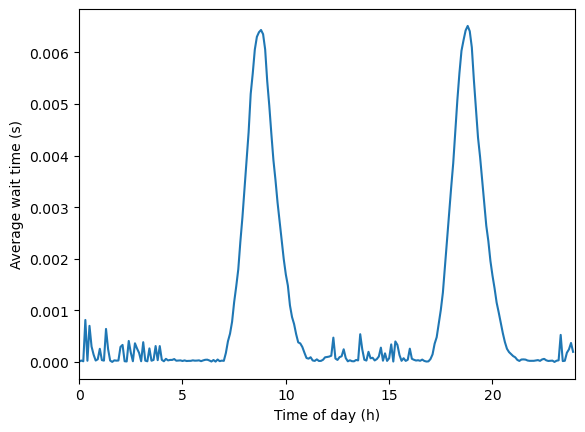

In [27]:
# Plot results
plt.plot(times, r1)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)

In [28]:
# 10 Servers with 10 cores each and 0.99 reliability, run 100 times
r2 = repeat_sim(20, 0.5, 20, 100)

100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


Text(0.5, 1.0, 'Average Request Wait Time \n (10 Servers with 10 cores each and 0.99 reliability)')

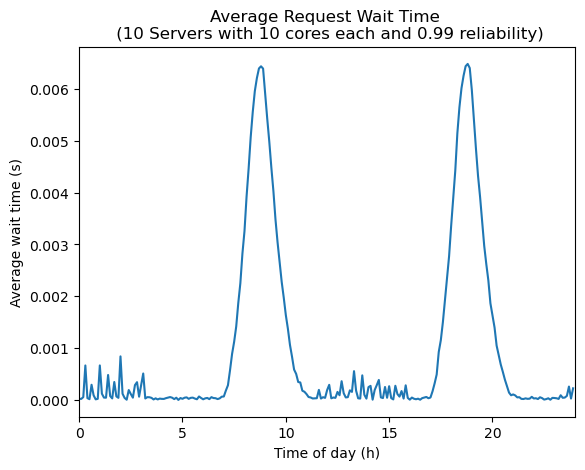

In [40]:
# Plot results
plt.plot(times, r2)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)
plt.title("Average Request Wait Time \n (10 Servers with 10 cores each and 0.99 reliability)")

In [32]:
print(np.mean(r1))
print(np.std(r1))
print(np.mean(r2))
print(np.std(r2))

0.000997191322165431
0.001781125213471436
0.0009876900534167002
0.0017719697925459598


In [282]:
# 5 Servers with 5 cores each and 0.99999 reliability, run 100 times
r3 = repeat_sim(5, 0.99999, 10, 100)

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


(0.0, 24.0)

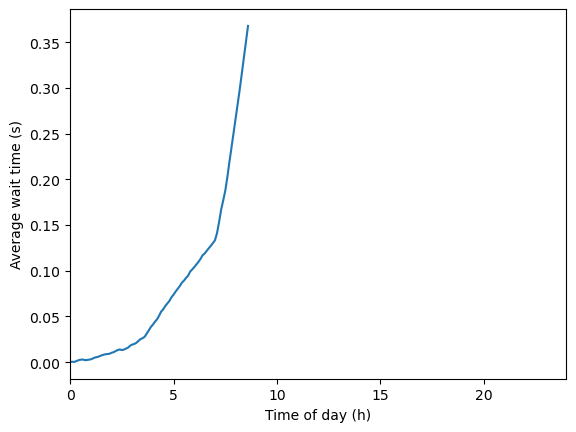

In [283]:
# Plot results
plt.plot(times, r3)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)

Text(0.5, 0.92, 'Cost of a server with given parameters of processing power and reliability')

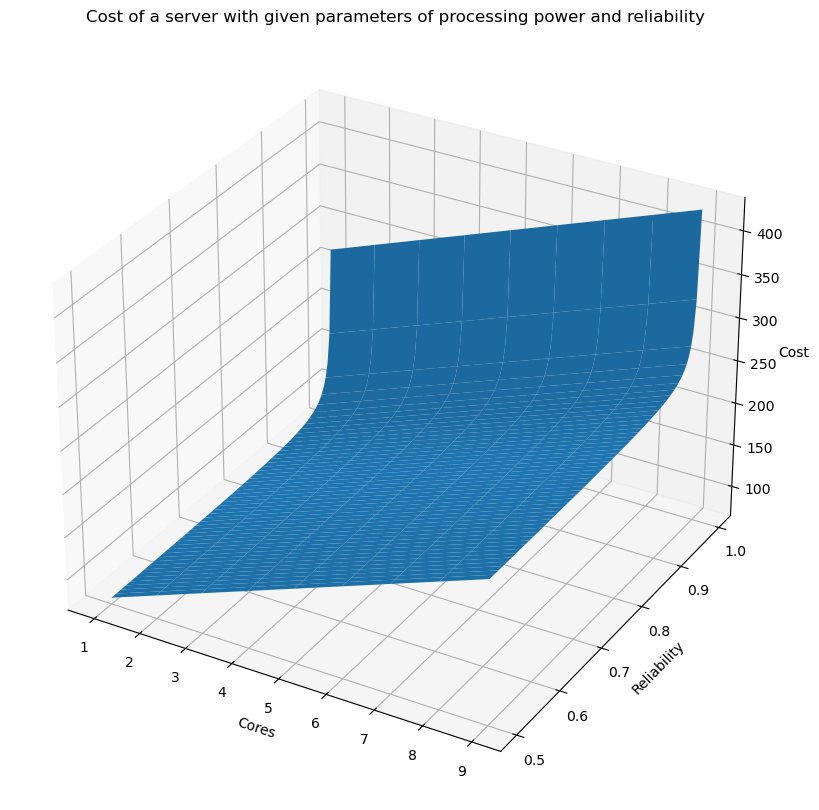

In [41]:
# Plot an interactive 3d contour plot of the Cost function with the parameters of cores and reliability

cores = np.arange(1, 10, 1)
reliability = np.arange(0.5, 1, 0.005)
cores, reliability = np.meshgrid(cores, reliability)
cost = Cost(cores, reliability)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(cores, reliability, cost)
ax.set_xlabel("Cores")
ax.set_ylabel("Reliability")
ax.set_zlabel("Cost")
ax.set_title("Cost of a server with given parameters of processing power and reliability")

In [16]:
# 100 servers with 10 cores each and 0.5 reliability, run 100 times
r4 = repeat_sim(100, 0.5, 10, 100)

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


(0.0, 24.0)

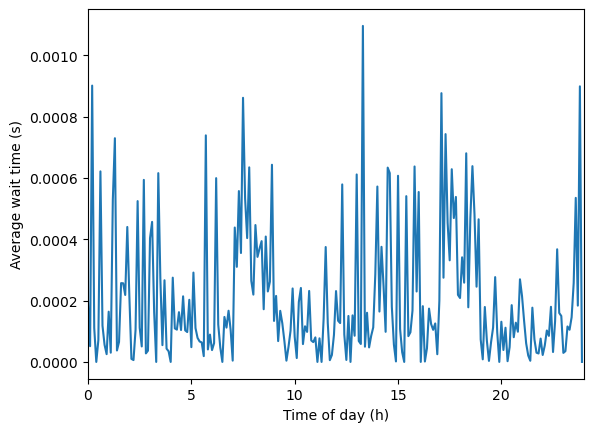

In [17]:
# Plot results
plt.plot(times, r4)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)

In [4]:
budget = 10000

In [2]:
# A function to calculate the number of servers that can be bought with a given budget and the parameters of cores and reliability
def num_servers(budget, cores, reliability):
    return int(budget/Cost(cores, reliability))

In [32]:
num_servers(budget, 400, 0.8)

1

In [44]:
# 1 server with 400 cores each and 0.8 reliability, run 100 times
r5 = repeat_sim(1, 0.8, 400, 100)

100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


(0.0, 24.0)

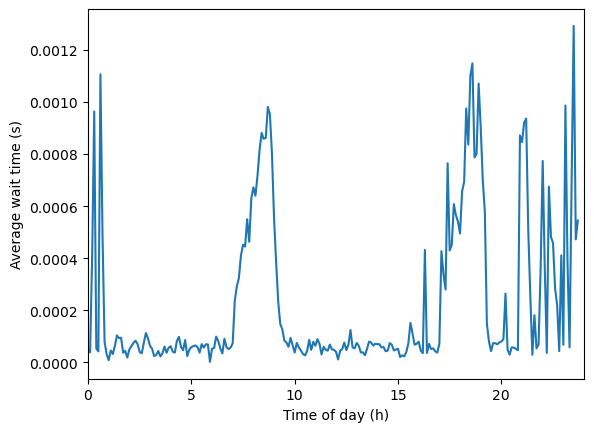

In [45]:
# Plot results
plt.plot(times, r5)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)


In [41]:
num_servers(budget, 4, 0.9998)

1

In [46]:
# 1 server with 4 cores each and 0.9998 reliability, run 100 times
r6 = repeat_sim(1, 0.9998, 4, 100)

100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


(0.0, 24.0)

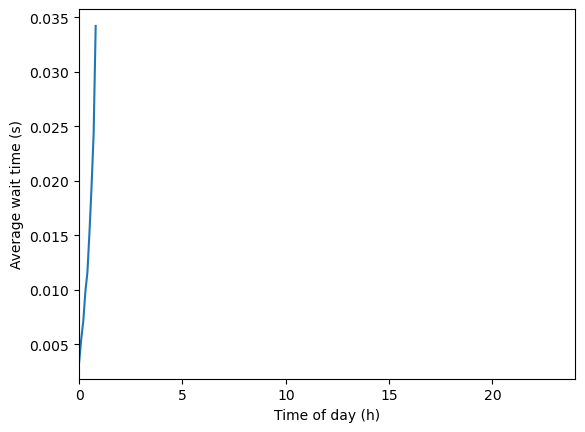

In [47]:
# Plot results
plt.plot(times, r6)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)

In [45]:
num_servers(budget, 4, 0.8)

74

In [48]:
# 74 server with 4 cores each and 0.8 reliability, run 100 times
r7 = repeat_sim(74, 0.8, 4, 100)

100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


(0.0, 24.0)

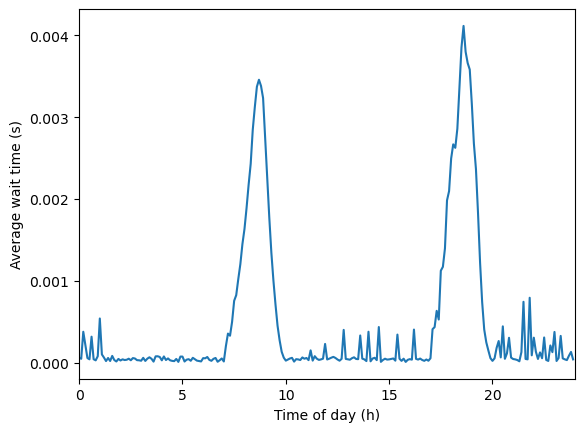

In [49]:
# Plot results
plt.plot(times, r7)
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)

Text(0.5, 1.0, 'Average Request Wait Time Over Course of a Day')

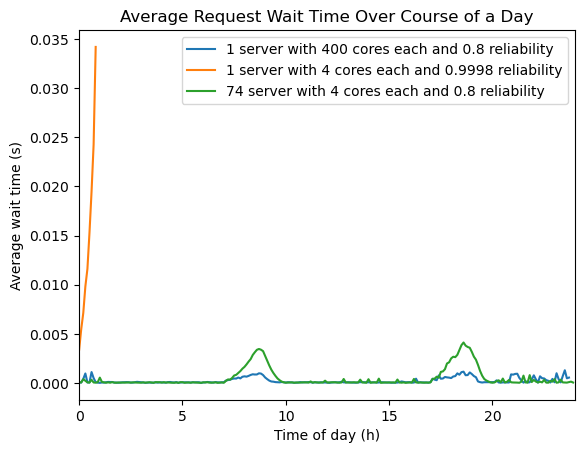

In [53]:
# Plot r5 r6 and r7 on the same graph
plt.plot(times, r5, label="1 server with 400 cores each and 0.8 reliability")
plt.plot(times, r6, label="1 server with 4 cores each and 0.9998 reliability")
plt.plot(times, r7, label="74 server with 4 cores each and 0.8 reliability")
plt.xlabel("Time of day (h)")
plt.ylabel("Average wait time (s)")
plt.xlim(0,24)
plt.legend()
plt.title("Average Request Wait Time Over Course of a Day")